# Reinforcement Learning

## Markov Chains (or Markov Processes)


In [1]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np
import os
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    # else:
    if (step == n_max_steps - 1):
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## MDP
- Let's define some transition probabilities, rewards and possible actions. For example, in state s0, if action a0 is chosen then with proba 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to state s1 with no reward, and with never go to state s2 (so the transition probabilities are [0.7, 0.3, 0.0], and the rewards are [+10, 0, 0]):

In [28]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0],
         [1.0, 0.0, 0.0],
         [0.8, 0.2, 0.0]],

        [[0.0, 1.0, 0.0],
         None,
         [0.0, 0.0, 1.0]],

        [None,
         [0.8, 0.1, 0.1],
         None]]

rewards = [ # shape=[s, a, s']
        [[+10, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, -50]],

        [[0, 0, 0],
         [+40, 0, 0],
         [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]

In [7]:
print(transition_probabilities[0][0])
print(rewards[0][0])
print(possible_actions[0])

[0.7, 0.3, 0.0]
[10, 0, 0]
[0, 1, 2]


## Dynamic Programming
- model-based (requires full knowledge of the MDP)
- it works by iteratively estimating value functions or policies until convergence.
- Value-iteration, Policy iteration
- 원래 의미는 문제를 작은 문제로 쪼개서 divide-and-conquer 방식으로 ietartion 을 통해해결하는 방법이지만 강화학습에서는 it still involves iterative processes that update estimates based on new information. (문제를 한 번에 푸는 게 아니라 여러 단계로 나누어 새로운 정보를 이용해 솔루션을 개선해 나가는 방법을 말함)
- Even though RL algorithms do not explicitly subdivide a problem into smaller ones, they do implicitly learn to solve smaller subproblems as part of the learning process. (처음에는 목적지 근처의 state 들이 최적의 값을 갖게 되고 iteration 이 지날수록 멀리 있는 state 들도 최적의 값을 찾아 가게 됨)

### Q-value Iteration
- model-based planning (building a model) and TD-like updates (value iteration)

In [8]:
Q_values = np.full((3, 3), -np.inf)    # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0     # for all possible actions

In [9]:
Q_values         # Q(s,a)

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [10]:
gamma = 0.90  # the discount factor
n_states = 3

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(n_states):           # for each state
        for a in possible_actions[s]:   # for each action
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(n_states)])

history1 = np.array(history1)

In [14]:
history1.shape

(50, 3, 3)

In [11]:
history1.round(2)[:3]   # the first 3 iterations

array([[[  0.  ,   0.  ,   0.  ],
        [  0.  ,   -inf,   0.  ],
        [  -inf,   0.  ,   -inf]],

       [[  7.  ,   0.  ,   0.  ],
        [  0.  ,   -inf, -50.  ],
        [  -inf,  32.  ,   -inf]],

       [[ 11.41,   6.3 ,   5.04],
        [  0.  ,   -inf, -21.2 ],
        [  -inf,  39.92,   -inf]]])

In [12]:
history1.round(2)[-3:]  # the last 3 iterations - can see it converged

array([[[18.92, 17.03, 13.62],
        [ 0.  ,  -inf, -4.88],
        [ -inf, 50.13,  -inf]],

       [[18.92, 17.03, 13.62],
        [ 0.  ,  -inf, -4.88],
        [ -inf, 50.13,  -inf]],

       [[18.92, 17.03, 13.62],
        [ 0.  ,  -inf, -4.88],
        [ -inf, 50.13,  -inf]]])

In [15]:
print(Q_values.round(2))

[[18.92 17.03 13.62]
 [ 0.    -inf -4.88]
 [ -inf 50.13  -inf]]


In [ ]:
print(np.argmax(Q_values, axis=1))  # action for each state

[0 0 1]


- 0.90의 할인 계수를 사용할 때 이 MDP에 대한 최적의 정책은 상태 s0에 있을 때 action a0을 선택하고 상태 s1에 있을 때 action a0을 선택하고 마지막으로 상태 s2에 있을 때 action a1(유일한 가능한 action)을 선택한다.

- Let's try again with a discount factor of 0.95:

In [16]:
# MDP withgamma=0.95

Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [17]:
Q_values.round(2)

array([[21.73, 20.64, 16.7 ],
       [ 0.95,  -inf,  1.01],
       [ -inf, 53.71,  -inf]])

In [18]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

- 이제 정책이 변경되었다. 상태 s1에서 우리는 이제 불을 통과하는 것을 선호한다 (액션 a2 선택). 할인 요인이 더 크기 때문에 에이전트는 미래를 더 중요하게 여기므로 더 많은 미래 보상을 얻기 위해 즉각적인 패널티를 지불할 준비가 되어 있기 때문이다.

## TD(Time Difference) methods
- model-free approach
- combines MonteCarlo and Dynamic Programming
- use Temporal Difference error to iteratively update value estimation

### Q-Learning
- Q-Learning은 Agent의 플레이를 관찰하고(예: 무작위로) Q-값의 추정치를 점진적으로 개선함으로써 작동한다. 정확한 Q-Value 추정값(또는 충분히 근접한)이 있으면 최적의 정책은 가장 높은 Q-Value를 갖는 작업을 선택한다. (Greedy Policy).



- Environment 를 대신하도록 새 상태와 보상을 가져오는 함수를 정의한다.

In [20]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

- 가능한 모든 상태를 여러 번 방문하는 할 수 있도록 탐색 정책이 필요하지만 여기서는 상태 공간이 매우 작기 때문에 무작위 정책을 사용한다.

In [21]:
np.random.seed(42)

# random policy
def random_policy(state):
    return np.random.choice(possible_actions[state])

# epsilon-greedy
def epsilon_greedy(state, epsilon=0.1):
    if np.random.rand() <= epsilon:   # random
        return np.random.choice(possible_actions[state])
    else:                             # greedy
        return np.argmax(Q_values[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [22]:
np.random.seed(42)

Q_values = np.full((3, 3), 0.0)    # initial values

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90  # discount factor
state = 0     # initial state
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = random_policy(state)             # exploration policy

    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy to update the value

    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)
print(Q_values.round(2))

[[18.78 17.22 13.75]
 [ 0.    0.   -8.  ]
 [ 0.   49.4   0.  ]]


In [23]:
history2.round(2)[-3:]   # converged

array([[[18.77, 17.22, 13.75],
        [ 0.  ,  0.  , -8.01],
        [ 0.  , 49.39,  0.  ]],

       [[18.77, 17.22, 13.75],
        [ 0.  ,  0.  , -8.  ],
        [ 0.  , 49.39,  0.  ]],

       [[18.77, 17.22, 13.75],
        [ 0.  ,  0.  , -8.  ],
        [ 0.  , 49.4 ,  0.  ]]])

In [24]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

In [26]:
Q_values.round(2)

array([[18.78, 17.22, 13.75],
       [ 0.  ,  0.  , -8.  ],
       [ 0.  , 49.4 ,  0.  ]])

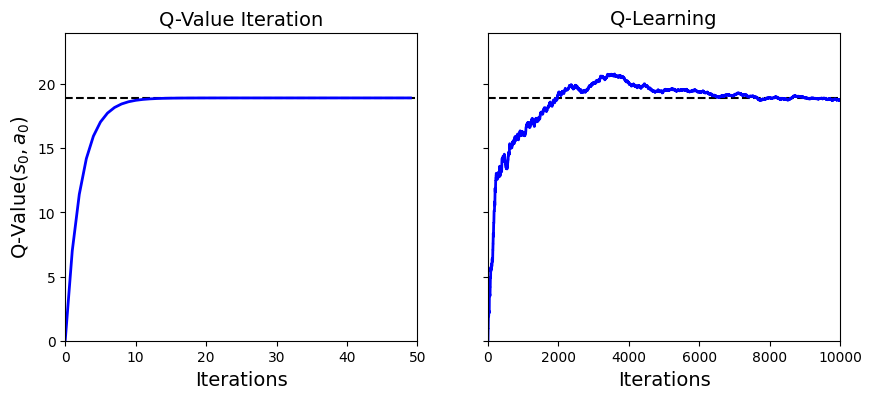

In [27]:
true_Q_value = history1[-1, 0, 0]  # last value of (s0,a0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

- 위의 그림은 Q_Value(s0,a0) 의 수렴 과정을 보이고 있다. 그림에서 보듯이, Q-Value 반복 알고리즘(왼쪽)은 20회 미만의 반복으로 매우 빠르게 수렴하는 반면 Q-Learning 알고리즘(오른쪽)은 수렴하는 데 약 8,000회 반복이 걸린다. 예상할 수 있듯이, 상태전이확률이나 보상을 모르면 최적의 정책을 찾는 것이 훨씬 더 어려워진다.
- exploration policy 로 epsilon-greedy 를 사용하면 수렴 시간이 달라진다.

### SARSA

In [29]:
np.random.seed(42)

Q_values = np.full((3, 3), 0.0)

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90  # discount factor
state = 0     # initial state
history3 = []

action = epsilon_greedy(state, 0.5)                 # exploration policy
for iteration in range(10000):
    history3.append(Q_values.copy())

    next_state, reward = step(state, action)
    next_action = epsilon_greedy(next_state, 0.5)   # on-policy

    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * Q_values[next_state, next_action])

    state, action = next_state, next_action

history3 = np.array(history3)

In [30]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 1, 1])

In [31]:
Q_values

array([[ 18.68431297,  12.62678443,  10.79421598],
       [  2.18636882,  18.05478514, -13.48558834],
       [  0.        ,  46.32817751,   0.        ]])

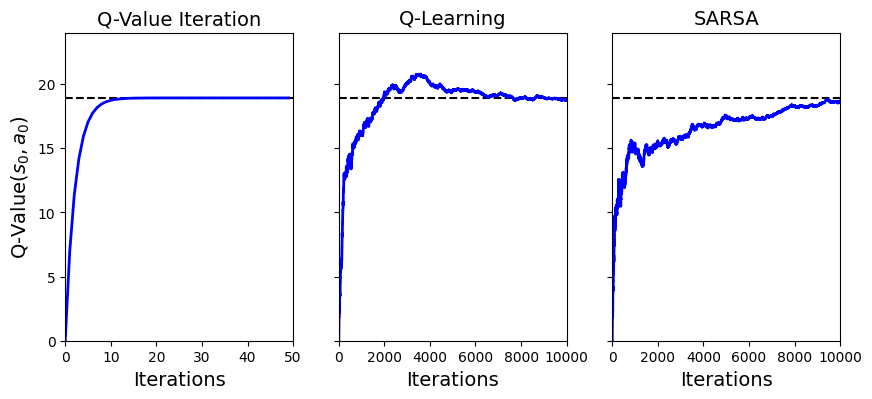

In [32]:
true_Q_value = history1[-1, 0, 0]  # last value of (s0,a0)

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
axes[2].set_title("SARSA", fontsize=14)
for ax, width, history in zip(axes, (50, 10000, 10000), (history1, history2, history3)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

# Exercise

- Dynamic Programming
 - divide
 - conquer + memoization
 - combine

In [38]:
# recursive call (exponential time complexity)
%%timeit
def F(n):
    if n == 0 or n == 1:
        return n
    else:
        return F(n-1)+F(n-2)

F(20)

4.84 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


- dynamic programming:
  - we store the solution somewhere and only calculate it once (not to calculate the same thing twice.)

In [41]:
# dynamic programming (linear time complexity)
%%timeit

def fibonacciVal(n):
    mem = [0] * (n+1)
    mem[0], mem[1] = 0, 1
    for i in range(2, n+1):
        mem[i] = mem[i-1] + mem[i-2]
    return mem[n]

fibonacciVal(20)

4.83 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


- The reason the recursive version is significantly slower than the dynamic programming version is because the recursive approach recalculates the Fibonacci numbers for smaller values multiple times. This results in a lot of redundant calculations and leads to exponential time complexity. In contrast, the dynamic programming version uses memoization to store and reuse previously computed Fibonacci numbers, which greatly reduces the number of calculations and results in a much faster execution time.